In [1]:
# %matplotlib notebook
import NN_Module as nnm
import torch
import numpy as np
import numpy.ma as ma
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import math
import time
import pandas as pd
from pandas import read_csv
import argparse

In [2]:
class Arguments:
    def __init__(self,min_output,max_output,nodes,layers,batch_size,epochs,learning_rate,learning_rate_reduction, \
                learning_rate_patience,learning_rate_threshold,weight_decay,accu_out_resolution,out_residual_resolution):
        self.min_output = min_output
        self.max_output = max_output
        self.nodes = nodes
        self.layers = layers
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.learning_rate_reduction = learning_rate_reduction
        self.learning_rate_patience = learning_rate_patience
        self.learning_rate_threshold = learning_rate_threshold
        self.weight_decay = weight_decay
        self.accu_out_resolution = accu_out_resolution
        self.out_residual_resolution = out_residual_resolution
args = Arguments(0, 500,700 ,2,512, 5,1e-4, 0.2, 20, 1e-6 ,0 ,100 ,100)

In [7]:
# Create a simple neural network with layer and node variabliltiy
def create_basic_model(input_dim, output_dim, parameters):
    """
    Creates a sequential model with the same number of nodes in each hidden layer.
    Inputs: input_dim (integer), output_dim (integer), parameters (dictionary)
    Outputs: model (Pytorch sequential container)
    """
    #layers = [poly.PolynomialLayer(16,2,parameters['hidden_nodes']), torch.nn.ReLU()]
    layers = [torch.nn.Linear(input_dim,parameters['hidden_nodes']),torch.nn.ReLU()]
    for i in range(parameters['hidden_layers']):
        layers.append(torch.nn.Linear(parameters['hidden_nodes'],parameters['hidden_nodes']))
        layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Linear(parameters['hidden_nodes'],output_dim)) # We only care about functions with one output
    model = torch.nn.Sequential(*layers)
    # include different number of nodes per layer functionality
    #list with nodes per layer
    return model.cuda()

In [4]:
# Load data sets
loaded_data = np.load('/scratch365/klannon/dnnlikelihood/likelihood_data_no_delta.npz')
deltaNLL = loaded_data['deltaNLL']-np.min(loaded_data['deltaNLL'])

# Tune proportion of outputs over 50 vs under 50
use_it_over = (deltaNLL >= 50) # Only keep the outputs > 50
use_it_under = (deltaNLL < 50) 
under_50_num = deltaNLL[use_it_under].size
over_50_num = deltaNLL[use_it_over].size
under_proportion = 1     # For now, these are set to use all the data as it is (without tweaks to proportion of over/under 50)
over_proportion = 1
index_under = np.random.choice(under_50_num, int(under_50_num*under_proportion), replace=False)
index_over = np.random.choice(over_50_num, int(over_50_num*over_proportion), replace=False)

# Load desired proportion of WC values
cQei = np.concatenate((loaded_data['cQei'][index_under], loaded_data['cQei'][index_over]), axis=0)
cQl3i = np.concatenate((loaded_data['cQl3i'][index_under], loaded_data['cQl3i'][index_over]), axis=0)
cQlMi = np.concatenate((loaded_data['cQlMi'][index_under], loaded_data['cQlMi'][index_over]), axis=0)
cbW = np.concatenate((loaded_data['cbW'][index_under], loaded_data['cbW'][index_over]), axis=0)
cpQ3 = np.concatenate((loaded_data['cpQ3'][index_under], loaded_data['cpQ3'][index_over]), axis=0)
cpQM = np.concatenate((loaded_data['cpQM'][index_under], loaded_data['cpQM'][index_over]), axis=0)
cpt = np.concatenate((loaded_data['cpt'][index_under], loaded_data['cpt'][index_over]), axis=0)
cptb = np.concatenate((loaded_data['cptb'][index_under], loaded_data['cptb'][index_over]), axis=0)
ctG = np.concatenate((loaded_data['ctG'][index_under], loaded_data['ctG'][index_over]), axis=0)
ctW = np.concatenate((loaded_data['ctW'][index_under], loaded_data['ctW'][index_over]), axis=0)
ctZ = np.concatenate((loaded_data['ctZ'][index_under], loaded_data['ctZ'][index_over]), axis=0)
ctei = np.concatenate((loaded_data['ctei'][index_under], loaded_data['ctei'][index_over]), axis=0)
ctlSi = np.concatenate((loaded_data['ctlSi'][index_under], loaded_data['ctlSi'][index_over]), axis=0)
ctlTi = np.concatenate((loaded_data['ctlTi'][index_under], loaded_data['ctlTi'][index_over]), axis=0)
ctli = np.concatenate((loaded_data['ctli'][index_under], loaded_data['ctli'][index_over]), axis=0)
ctp = np.concatenate((loaded_data['ctp'][index_under], loaded_data['ctp'][index_over]), axis=0)

# Load desired proportion of outputs
outputs_all = np.concatenate((deltaNLL[index_under], deltaNLL[index_over]), axis=0)

# Store values in list
inputs_all = []
inputs_all.append(cQei)
inputs_all.append(cQl3i)
inputs_all.append(cQlMi)
inputs_all.append(cbW)
inputs_all.append(cpQ3)
inputs_all.append(cpQM)
inputs_all.append(cpt)
inputs_all.append(cptb)
inputs_all.append(ctG)
inputs_all.append(ctW)
inputs_all.append(ctZ)
inputs_all.append(ctei)
inputs_all.append(ctlSi)
inputs_all.append(ctlTi)
inputs_all.append(ctli)
inputs_all.append(ctp)
inputs_all = np.stack(inputs_all, axis=1)


In [5]:
# Randomize
all = np.concatenate([inputs_all, np.expand_dims(outputs_all, axis=1)], axis=1)
np.random.shuffle(all)
inputs_all = all[:,:-1]
outputs_all = all[:,-1]

# # Take desired fraction of data (for memory purposes)
total_data = loaded_data['deltaNLL'].size
#use_proportion = 0.16
#use_proportion = 2e-02
use_proportion = 1
index_data = np.random.choice(total_data, int(total_data*use_proportion), replace=False)
inputs_all = inputs_all[index_data]
outputs_all = outputs_all[index_data]

# Add the squares of the variables and cross terms
inputs_list = []
inputs_list.append(inputs_all)
# inputs_all_squared = inputs_all ** 2
# inputs_list.append(inputs_all_squared)

# Add the cross terms
# for i in range(16):
#     for j in range(i):
#         inputs_list.append(np.expand_dims(inputs_all[:,i] *  inputs_all[:,j], axis=1))
# inputs_all = np.concatenate(inputs_list, axis=1)

In [8]:
# Save only the points with output in given range
min_out = args.min_output
max_out = args.max_output
use_range = (outputs_all >= min_out) & (outputs_all < max_out)
outputs_all = outputs_all[use_range]
inputs_all = inputs_all[use_range]

# Prepare to split into training and validation sets
total_data = outputs_all.shape[0]
train_proportion = 0.99
validation_proportion = 0.01

# Create a representative validation set
index_test = np.random.choice(total_data, round(total_data*validation_proportion), replace=False)
test_inputs = inputs_all[index_test]
test_outputs = outputs_all[index_test]
inputs = np.delete(inputs_all, index_test, axis=0)
outputs = np.delete(outputs_all, index_test, axis=0)

inputs = torch.from_numpy(inputs).cuda()
outputs = torch.unsqueeze(torch.from_numpy(outputs).cuda(), 1)
test_inputs = torch.from_numpy(test_inputs).cuda()
test_outputs = torch.unsqueeze(torch.from_numpy(test_outputs).cuda(), 1)

# Hyperparameters
parameters = {}
parameters['N'] = inputs.shape[1]
parameters['train_size'] = inputs.shape[0]
parameters['test_size'] = test_inputs.shape[0]
parameters['hidden_nodes'] = args.nodes
parameters['hidden_layers'] = args.layers
parameters['batch_size'] = args.batch_size
parameters['n_epochs'] = args.epochs
parameters['learning_rate'] = args.learning_rate
parameters['lr_red_factor'] = args.learning_rate_reduction
parameters['lr_red_patience'] = args.learning_rate_patience
parameters['lr_red_threshold'] = args.learning_rate_threshold
parameters['weight_decay'] = args.weight_decay

# Graphing parameters
parameters['accu_out_resolution'] = args.accu_out_resolution
parameters['out_residual_resolution'] = args.out_residual_resolution

# Standardize data sets
input_stats = nnm.find_stats(inputs)
output_stats = nnm.find_stats(outputs)
std_inputs = nnm.affine_transform(inputs, input_stats)
std_test_inputs = nnm.affine_transform(test_inputs, input_stats) # Not actually normal; Only std_inputs is normal
std_outputs = nnm.affine_transform(outputs, output_stats)
std_test_outputs = nnm.affine_transform(test_outputs, output_stats)

# Create a representative training set
index_std_train_rep = np.random.choice(parameters['train_size'], parameters['test_size'], replace=False)
std_inputs_rep = std_inputs[index_std_train_rep]
std_outputs_rep = std_outputs[index_std_train_rep]

# Create a model
model = create_basic_model(inputs.shape[1], outputs.shape[1], parameters)

# Train the model
(graph_data, best_model_state, parameters_save) = nnm.train_network(model, std_inputs, std_outputs, std_test_inputs, std_test_outputs, output_stats, std_inputs_rep, std_outputs_rep, parameters)

=>Starting 1/5 epochs.
Training done!
--- 715.4451983040199 seconds ---
Best accuracy:  0.547115527272873 , achieved in  4 epochs


{'fig_time': <Figure size 432x288 with 1 Axes>,
 'ax_time': <AxesSubplot:xlabel='Epochs', ylabel='Time (s)'>,
 'fig_param': <Figure size 432x288 with 1 Axes>,
 'ax_param': <AxesSubplot:>,
 'fig_loss': <Figure size 432x288 with 1 Axes>,
 'ax_loss': <AxesSubplot:xlabel='Epochs', ylabel='Loss (After Standardization; MSE)'>,
 'fig_accu': <Figure size 432x288 with 1 Axes>,
 'ax_accu': <AxesSubplot:xlabel='Epochs', ylabel='Accuracy'>,
 'fig_accu_out': <Figure size 432x288 with 3 Axes>,
 'ax_out_freq': <AxesSubplot:xlabel='Frequency', ylabel='Outputs'>,
 'ax_accu_out': <AxesSubplot:xlabel='Epochs', ylabel='Outputs'>,
 'fig_out_residual': <Figure size 432x288 with 2 Axes>,
 'ax_out_residual': <AxesSubplot:xlabel='True Outputs', ylabel='Residual (actual - prediction)'>,
 'fig_weights': <Figure size 432x288 with 1 Axes>,
 'ax_weights': <AxesSubplot:title={'center':'Weights'}, xlabel='Weights'>,
 'fig_biases': <Figure size 432x288 with 1 Axes>,
 'ax_biases': <AxesSubplot:title={'center':'Biases'}

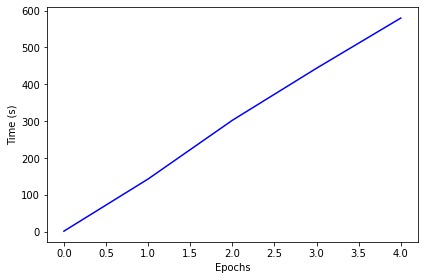

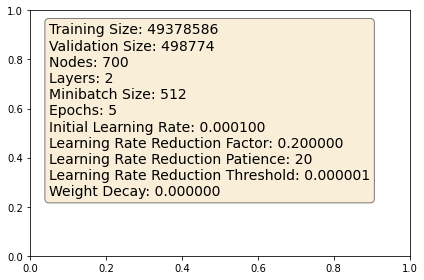

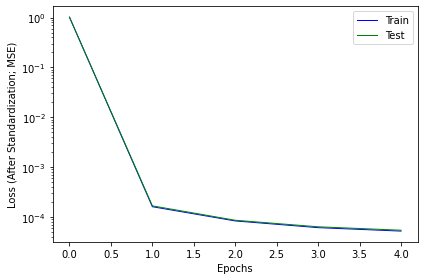

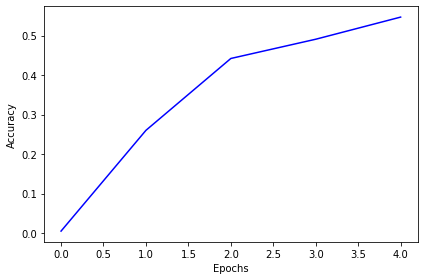

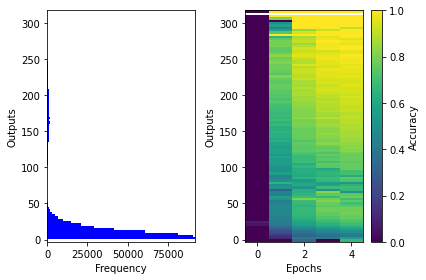

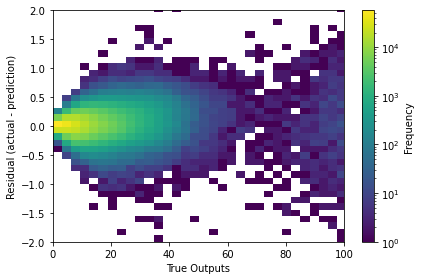

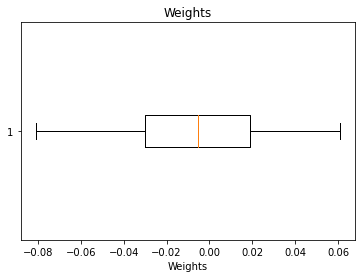

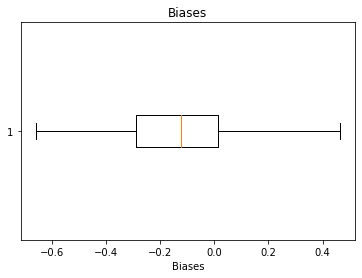

In [9]:
# Graphing
graphs = nnm.new_graphs()
nnm.graphing(graphs, graph_data, parameters)

# Save all graphs
#nnm.save_graphs(graphs, f'./graphs/{args.out_file}.pdf')

# Save the model, parameters, and standardization stats
#save_dict = {'model': best_model_state, 'parameters': parameters_save, 'input_stats': input_stats, 'output_stats': output_stats}
#torch.save(save_dict, f'./models/{args.out_file}_model+.pt')

# See pytorch version
# print (torch.__version__)
